<a href="https://colab.research.google.com/github/MarriumJilani/Comparative-Analysis-of-Human-Pose-Estimation-Models-for-Yoga-Poses/blob/main/YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

# Move the uploaded file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# Replace 'dataset-url' with the actual URL of the dataset
!kaggle datasets download -d niharika41298/yoga-poses-dataset



 98% 281M/288M [00:02<00:00, 140MB/s]
100% 288M/288M [00:02<00:00, 109MB/s]


In [ ]:
#!rm -r /content/dataset/

In [ ]:
# Unzip the downloaded dataset
!unzip -q /content/yoga-poses-dataset.zip -d dataset

In [ ]:
!ls
!ls /content/dataset
!ls /content/dataset/DATASET
!ls /content/dataset/DATASET/TEST
!ls /content/dataset/DATASET/TRAIN

dataset  runs  sample_data  yoga-poses-dataset.zip  yolov8n-pose.pt
DATASET
TEST  TRAIN
downdog  goddess  plank  tree  warrior2
downdog  goddess  plank  tree  warrior2


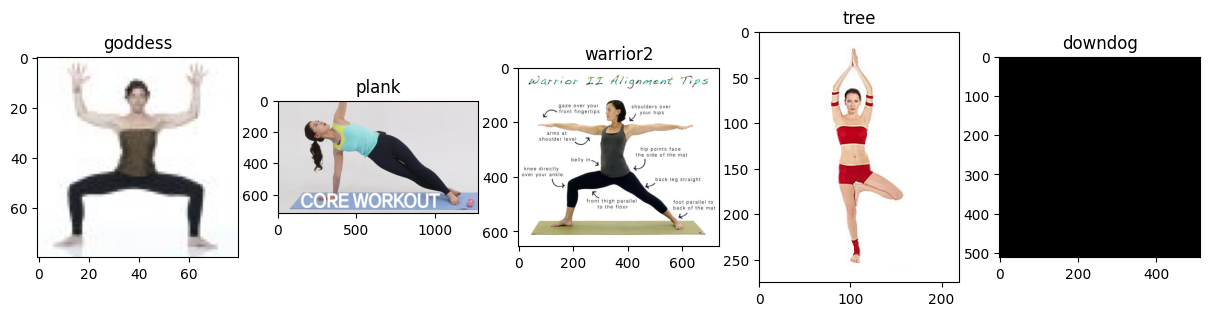

In [ ]:
import os
# Load the dataset
data_path = '/content/dataset/DATASET'
train_path = os.path.join(data_path, 'TRAIN')
test_path = os.path.join(data_path, 'TEST')

# Use the OS library to list classes in the dataset
classes = os.listdir(train_path)

# Visualize one sample for each class
import matplotlib.pyplot as plt
import cv2

# Display one sample image for each class
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

for i, class_label in enumerate(classes):
    class_path = os.path.join(train_path, class_label)
    sample_image = os.path.join(class_path, os.listdir(class_path)[0])
    image = cv2.imread(sample_image)
    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(class_label)

plt.show()




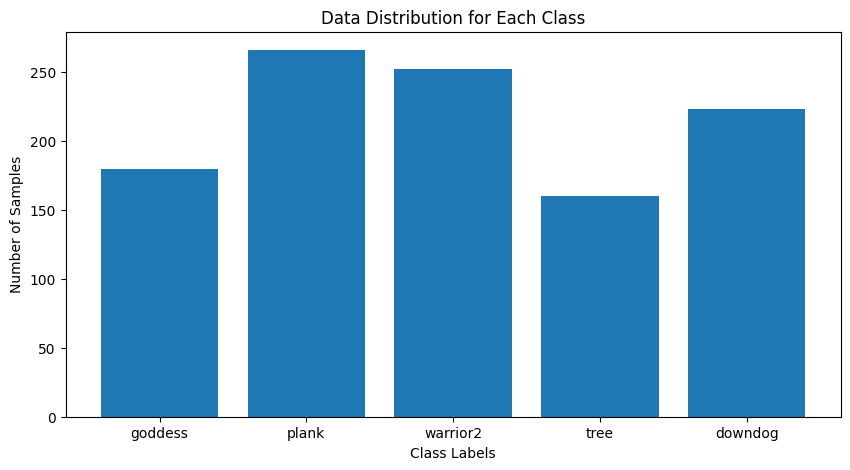

In [ ]:
# Graphical data distribution for each class using a bar chart
class_counts = {class_label: len(os.listdir(os.path.join(train_path, class_label))) for class_label in classes}

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Data Distribution for Each Class")
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.show()

# Check for class imbalances
min_samples = min(class_counts.values())
max_samples = max(class_counts.values())
class_imbalance_threshold = 0.8

if max_samples / min_samples > class_imbalance_threshold:
    print("Warning: There might be class imbalance.")
else:
    print("No significant class imbalance observed.")

In [ ]:
import cv2

# Load an example image from your dataset
example_image_path = "/content/dataset/DATASET/TEST/downdog/00000000.jpg"
example_image = cv2.imread(example_image_path)

# Get the image dimensions
img_height, img_width, _ = example_image.shape

print("Image Height:", img_height)
print("Image Width:", img_width)


Image Height: 720
Image Width: 1280


In [ ]:
!ls /content/dataset/DATASET/TEST
!ls /content/dataset/DATASET/TRAIN

downdog  goddess  plank  tree  warrior2
downdog  goddess  plank  tree  warrior2


# YOLOv8

In [ ]:
!pip install ultralytics opencv-python


In [ ]:
import os
import cv2
import numpy as np
import shutil
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # tqdm for progress bar

def create_yolo_annotation(image_path, class_index, keypoints):
    # Check if no keypoints are detected
    if keypoints.shape[0] == 0:
        print(f"No valid keypoints detected in {image_path}. Skipping annotation.")
        return

    # Determine the output annotation file path based on the image path
    annotation_path = os.path.splitext(image_path)[0] + '.txt'

    img = cv2.imread(image_path)
    height, width, _ = img.shape
    num_persons, num_keypoints = keypoints.shape[:2]

    # Check if no keypoints are detected
    if num_keypoints == 0:
        print(f"No valid keypoints detected in {image_path}. Skipping annotation.")
        return

    # Calculate divisor based on the actual number of keypoints
    divisor = np.array([width, height] * (num_keypoints + 2), dtype=float)

    with open(annotation_path, 'w') as file:
        for person_index in range(num_persons):
            # Extract keypoints for the current person
            person_keypoints = keypoints[person_index]

            # Normalize bounding box and keypoints
            normalized_bbox = np.array([0.5, 0.5, 1.0, 1.0], dtype=float)  # Example bounding box, adjust as needed
            normalized_keypoints = np.concatenate((normalized_bbox, person_keypoints.flatten())) / divisor

            # Write annotation to file
            file.write(f"{class_index} {' '.join(map(str, normalized_keypoints))}\n")

    print(f"Annotations created for {num_persons} persons in {image_path}.")




In [ ]:

def generate_yolo_config(train_path, test_path, class_names, kpt_shape, output_path):
    with open(output_path, 'w') as file:
        file.write(f"train: {train_path}\n")
        file.write(f"val: {test_path}\n")
        file.write(f"nc: {len(class_names)}\n")
        file.write(f"kpt_shape: {kpt_shape}\n")
        file.write(f"names: {class_names}")


In [ ]:
from ultralytics import YOLO

# Step 4: Train YOLOv8 Model

import subprocess

def train_yolov8(yolo_config_path, epochs=8):
    # Download the official YOLOv8 model using the Ultralytics CLI
    subprocess.run(['yolo', 'models/download', 'yolov8n-pose'])

    # Train the YOLOv8 model using the Ultralytics CLI and capture the output
    process = subprocess.Popen(['yolo', 'train', f'data={yolo_config_path}', 'model=yolov8n-pose.pt', f'epochs={epochs}'],
                               stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    # Print the captured output (you can modify this part based on your needs)
    print("Training Output:", stdout.decode())
    print("Training Error:", stderr.decode())

    # Return the captured output
    return stdout, stderr

# Main process
dataset_path = "/content/dataset/DATASET"
train_path = os.path.join(dataset_path, "TRAIN")
test_path = os.path.join(dataset_path, "TEST")

class_names = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

In [ ]:

model = YOLO('yolov8n-pose.pt')

# Create YOLO annotation files for training set
for class_index, class_name in enumerate(class_names):
    class_dir = os.path.join(train_path, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        annotation_path = os.path.join(class_dir, image_name.replace('.jpg', '.txt'))

        # Check if the image is either a .jpg or .png file
        if image_path.lower().endswith(('.jpg', '.png')):
            # Predict keypoints using the model
            results = model(image_path)

            # Extract keypoints from the results
            keypoints = results[0].keypoints.xy

            # Create YOLO annotation file with actual keypoints
            create_yolo_annotation(image_path, class_index, keypoints.cpu().numpy())

# Create YOLO annotation files for test set
for class_index, class_name in enumerate(class_names):
    class_dir = os.path.join(test_path, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        annotation_path = os.path.join(class_dir, image_name.replace('.jpg', '.txt'))

        # Check if the image is either a .jpg or .png file
        if image_path.lower().endswith(('.jpg', '.png')):
            # Predict keypoints using the model
            results = model(image_path)

            # Extract keypoints from the results
            keypoints = results[0].keypoints.xy

            # Create YOLO annotation file with actual keypoints
            create_yolo_annotation(image_path, class_index, keypoints.cpu().numpy())


Streaming output truncated to the last 5000 lines.

image 1/1 /content/dataset/DATASET/TRAIN/goddess/00000216.jpg: 640x448 4 persons, 139.4ms
Speed: 1.9ms preprocess, 139.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)
Annotations created for 4 persons in /content/dataset/DATASET/TRAIN/goddess/00000216.jpg.

image 1/1 /content/dataset/DATASET/TRAIN/goddess/00000130.jpg: 416x640 1 person, 129.5ms
Speed: 1.8ms preprocess, 129.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)
Annotations created for 1 persons in /content/dataset/DATASET/TRAIN/goddess/00000130.jpg.

image 1/1 /content/dataset/DATASET/TRAIN/goddess/00000346.jpg: 640x640 1 person, 185.4ms
Speed: 2.9ms preprocess, 185.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Annotations created for 1 persons in /content/dataset/DATASET/TRAIN/goddess/00000346.jpg.

image 1/1 /content/dataset/DATASET/TRAIN/goddess/00000358.jpg: 480x640 1 person, 140.9ms
Speed: 2.5ms preprocess,

In [ ]:
def determine_max_persons(dataset_path):
    max_persons = 0
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                annotation_path = os.path.splitext(os.path.join(root, file))[0] + '.txt'
                if os.path.exists(annotation_path):
                    with open(annotation_path, 'r') as ann_file:
                        num_persons = sum(1 for line in ann_file)
                        max_persons = max(max_persons, num_persons)
    return max_persons

print(determine_max_persons('/content/dataset/DATASET/TRAIN/warrior2'))

14


In [ ]:
# Split dataset into train and test
train_test_split_path = "/content/dataset/DATASET_SPLIT"
shutil.rmtree(train_test_split_path, ignore_errors=True)
os.makedirs(train_test_split_path)

In [ ]:
max_persons=14

# Create TRAIN and TEST folders for each pose
for class_name in class_names:
    train_class_dir = os.path.join(train_test_split_path, "TRAIN", class_name)
    test_class_dir = os.path.join(train_test_split_path, "TEST", class_name)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Get the list of images and annotation files for the current pose
    class_dir_train = os.path.join(dataset_path, "TRAIN", class_name)
    class_dir_test = os.path.join(dataset_path, "TEST", class_name)

    train_images = [file for file in os.listdir(class_dir_train) if file.lower().endswith(('.jpg', '.png'))]
    test_images = [file for file in os.listdir(class_dir_test) if file.lower().endswith(('.jpg', '.png'))]

    # Copy images and annotation files to TRAIN folder
    for image_name in train_images:
        image_path = os.path.join(class_dir_train, image_name)
        annotation_name = os.path.splitext(image_name)[0] + ".txt"
        annotation_path_src = os.path.join(class_dir_train, annotation_name)
        annotation_path_dst = os.path.join(train_class_dir, annotation_name)

        # Check if the annotation file exists before copying
        if os.path.exists(annotation_path_src):
            shutil.copy(image_path, os.path.join(train_class_dir, image_name))
            shutil.copy(annotation_path_src, annotation_path_dst)
            # Call the function to create YOLO annotations
            create_yolo_annotation(image_path, class_names.index(class_name), np.zeros((1, 17, 2)))
        else:
            print(f"Annotation file not found for {image_path}. Skipping.")

    # Copy images and annotation files to TEST folder
    for image_name in test_images:
        image_path = os.path.join(class_dir_test, image_name)
        annotation_name = os.path.splitext(image_name)[0] + ".txt"  # Use the same name for annotation file with PNG images
        annotation_path_src = os.path.join(class_dir_test, annotation_name)
        annotation_path_dst = os.path.join(test_class_dir, annotation_name)

        # Check if the annotation file exists before copying
        if os.path.exists(annotation_path_src):
            shutil.copy(image_path, os.path.join(test_class_dir, image_name))
            shutil.copy(annotation_path_src, annotation_path_dst)
        else:
            print(f"Annotation file not found for {image_path}. Skipping.")




Annotation file not found for /content/dataset/DATASET/TRAIN/downdog/00000188.png. Skipping.
Annotations created for 1 persons in /content/dataset/DATASET/TRAIN/downdog/00000348.jpg.
Annotations created for 1 persons in /content/dataset/DATASET/TRAIN/downdog/00000301.jpg.
Annotations created for 1 persons in /content/dataset/DATASET/TRAIN/downdog/00000244.jpg.
Annotations created for 1 persons in /content/dataset/DATASET/TRAIN/downdog/00000409.jpg.
Annotations created for 1 persons in /content/dataset/DATASET/TRAIN/downdog/00000240.jpg.
Annotation file not found for /content/dataset/DATASET/TRAIN/downdog/00000287.png. Skipping.
Annotations created for 1 persons in /content/dataset/DATASET/TRAIN/downdog/00000365.jpg.
Annotations created for 1 persons in /content/dataset/DATASET/TRAIN/downdog/00000343.jpg.
Annotations created for 1 persons in /content/dataset/DATASET/TRAIN/downdog/00000392.jpg.
Annotations created for 1 persons in /content/dataset/DATASET/TRAIN/downdog/00000132.png.
Anno

In [ ]:
# Generate YOLO configuration file
yolo_config_path = "/content/dataset/your_dataset.yaml"
generate_yolo_config(
    os.path.join(train_test_split_path, "TRAIN"),
    os.path.join(train_test_split_path, "TEST"),
    class_names,
    [17, 2],
    yolo_config_path
)


In [ ]:
!pip install -U ultralytics


In [ ]:
# Train YOLOv8 model and capture the results
training_stdout, training_stderr = train_yolov8(yolo_config_path, epochs=8)


Training Output: Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (AMD EPYC 7B12)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=/content/dataset/your_dataset.yaml, epochs=8, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt


image 1/1 /content/dataset/DATASET_SPLIT/TEST/warrior2/00000117.jpg: 448x640 1 person, 108.3ms
Speed: 2.4ms preprocess, 108.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


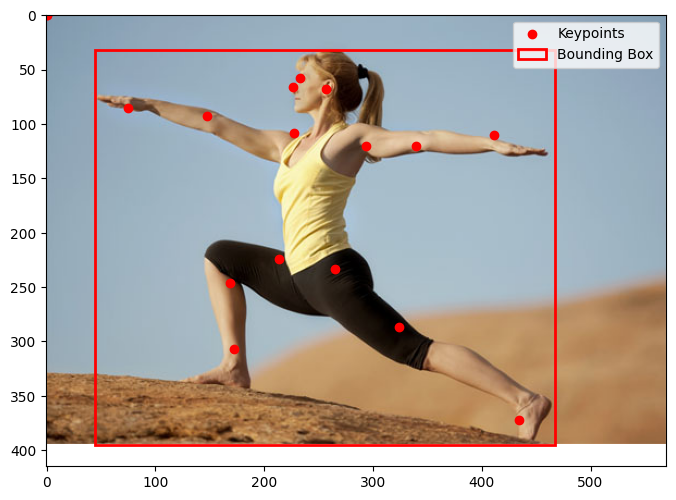


image 1/1 /content/dataset/DATASET_SPLIT/TEST/goddess/00000001.jpg: 288x640 1 person, 89.2ms
Speed: 1.9ms preprocess, 89.2ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


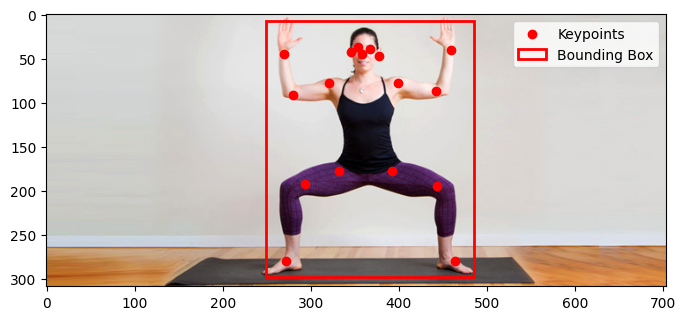


image 1/1 /content/dataset/DATASET_SPLIT/TEST/plank/00000002.jpg: 352x640 1 person, 88.7ms
Speed: 2.0ms preprocess, 88.7ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


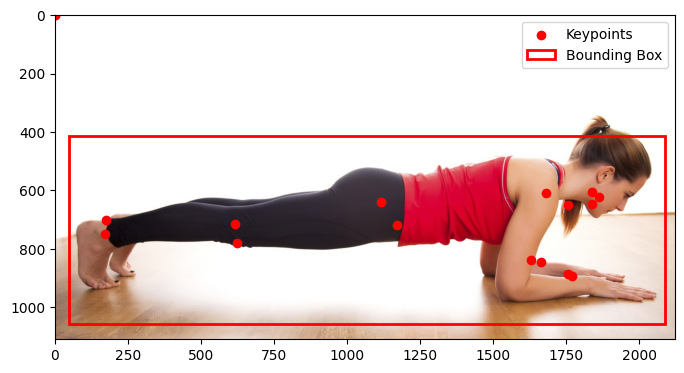


image 1/1 /content/dataset/DATASET_SPLIT/TEST/tree/00000068.png: 640x448 1 person, 120.7ms
Speed: 2.3ms preprocess, 120.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


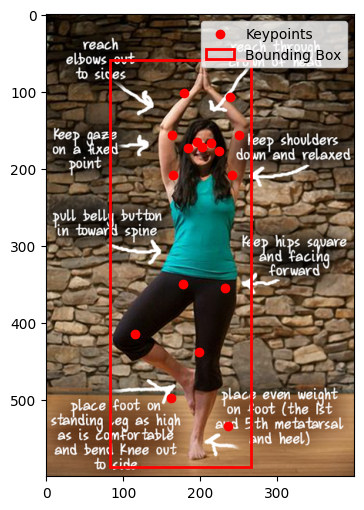

In [ ]:
import os
import shutil
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image


# Visualize keypoints on a few images
# Specify paths to test images
test_image_paths = [
    '/content/dataset/DATASET_SPLIT/TEST/warrior2/00000117.jpg',
    '/content/dataset/DATASET_SPLIT/TEST/goddess/00000001.jpg',
    '/content/dataset/DATASET_SPLIT/TEST/plank/00000002.jpg',
    '/content/dataset/DATASET_SPLIT/TEST/tree/00000068.png'

]

for test_image_path in test_image_paths:
    # Predict keypoints using the trained model
    results = model(test_image_path)

    # Extract keypoints and visualize
    keypoints = results[0].keypoints.xy
    boxes = results[0].boxes.data

    # Visualize bounding box and keypoints on the image
    img = cv2.imread(test_image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.scatter(keypoints[0][:, 0], keypoints[0][:, 1], c='r', label='Keypoints')
    plt.gca().add_patch(plt.Rectangle((boxes[0, 0], boxes[0, 1]), boxes[0, 2] - boxes[0, 0], boxes[0, 3] - boxes[0, 1],
                                     linewidth=2, edgecolor='r', facecolor='none', label='Bounding Box'))
    plt.legend()
    plt.show()


In [ ]:
import shutil
shutil.make_archive('/content/run_info', 'zip', '/content/runs')


'/content/run_info.zip'

In [ ]:
from google.colab import files
files.download('/content/run_info.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>